# Functional Connectivity Analysis
***

Now we have an idea of three important components to analyzing neuroimaging data:

1. Data manipulation
2. Cleaning and confound regression
3. Parcellation and signal extraction

In this notebook the goal is to integrate these 3 basic components and perform a full analysis of group data using **Seed-based Functional Connectivity (FC)**. 

Seed-based functional connectivity is essentially a result of performing correlational analysis on signals extracted from an ROI with voxels. Using this technique we can establish highly correlative regions in resting state data which form **functional networks**. 

This analysis forms a basis for many other sophisticated techniques in neuroimaging research. 

## Notebook Outline
***

The outline of the notebook is divided into two parts. The first part directly uses what you've learned and builds upon it to perform the final functional connectivity analysis on group data. 

The second part shows how we can use Nilearn's convenient wrapper functionality to perform the same task with *significantly less effort*. 

#### Part A: Manual computation 
1. Functional data cleaning and confound regression
2. Applying a parcellation onto the data
3. Seed-based functional connectivity analysis
4. Visualization

#### Part B: Using Nilearn's high-level features
1. Using NiftiMapsMasker to extract cleaned time-series
2. Performing seed-based functional connectivity analysis
3. Visualization

In [10]:
import os
from nilearn import signal as sgl
from nilearn import image as img
from nilearn import plotting as plot
from nilearn import datasets
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Setting up directories
func_dir = '../data/func/'
func_file = 'sub-10206_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
func_path = os.path.join(func_dir,func_file) 

confound_file = 'sub-10206_task-rest_bold_confounds.tsv'
confound_path = os.path.join(func_dir,confound_file) 

### Part A: Manual Computation of Seed-based functional connectivity
***

#### 1. Cleaning your functional data using filtering, dummy TR removal and confound regression
The first step to any functional analysis is to clean the data. We're going to make a python function that will handle confound cleaning for us:

In [14]:
#Refer to part_06 for full code + explanation
def clean_image(func_img,confounds,tr_drop=4,low_pass=0.08,high_pass=0.009):
    
    '''
    Arguments:
        func_img                        Nibabel Nifti1Image of functional data
        confounds                       Confound matrix (timepoints)x(variable) matrix
        tr_drop                         Number of frames to drop from beginning
        low_pass                        Low pass cutoff [default = 0.08]
        high_pass                       High pass cutoff [default = 0.009]
        
    Output:
        clean_img                       Cleaned version of func_img (Nifti1Image) 
    '''
    
    #Extract affine matrix from data, will need it to re-form a Nifti1Image
    affine = func_img.affine
    
    #Implement TR drop for data and confounds
    func_img = func_img.slicer[:,:,:,(tr_drop)+1:]
    confounds = confounds[(tr_drop)+1:,:]
    
    #Pull data from functional image
    data = func_img.get_data()
    
    #Get functional data dimensions
    x,y,z,t = data.shape
    
    #Reshape data so that it is a (t)*(x*y*z) matrix then flip
    shaped_data = data.reshape([x*y*z,t]).transpose()
    
    #Use sgl.clean
    clean_data = sgl.clean(shaped_data,confounds=confounds,low_pass=low_pass,high_pass=high_pass)
    
    #Flip data then reshape back into 4D volume
    clean_vol = clean_data.transpose().reshape([x,y,z,t])
    
    #Create Nifti1Image
    clean_img = nib.Nifti1Image(clean_vol,affine) 
    
    #Return cleaned image
    return clean_img

We're also going to define a function to handle converting our confounds.tsv into a matrix

In [15]:
#Refer to part_06 for code + explanation
def extract_confounds(confound_tsv,confounds,dt=True):
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confounds                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
    #If using temporal derivatives 
    if dt:
        #For each column create a new column '<colname>_dt' containing the step-wise differences
        for col in confound_df.columns:
            confound_df['{}_dt'.format(col)] = confound_df[col].diff() 
    
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat
    

Let's clean our data!

In [17]:
#Load functional image
func_img = img.load_img(func_path)

#Extract confounds
confounds = extract_confounds(confound_path,['X','Y','Z','RotX','RotY','RotZ',
                                             'aCompCor01','aCompCor02','GlobalSignal'])

#Clean functional image
clean_img = clean_image(func_img,confounds) 

#### 2. Setting up the parcellation scheme

To apply a parcellation we'll have to specify a parcellation to use. 
For this analysis we'll be using [Craddock 2012 - 200 ROIs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3838923/) as our parcellation scheme since it contains relatively simple ROIs that won't be too difficult to work with...

First we'll pull in our parcellation then extract the version containing 200 ROIs

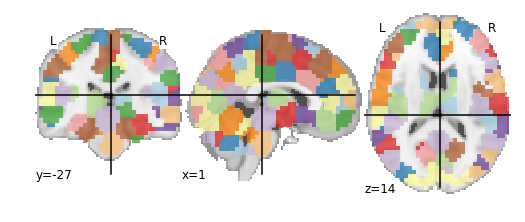

In [40]:
parcel_dir = '../resources/rois/' 
fetch_atlas = datasets.fetch_atlas_craddock_2012(parcel_dir) 

#Notice cc_atlas is 4D, where the 4th dimension contains different types of parcellations
cc_atlas = img.load_img(fetch_atlas['random']) 

#Index 19, contains the 200 ROI parcellation we want to use
cc200 = cc_atlas.slicer[:,:,:,19]

#Let's visualize it
plot.plot_roi(cc200,cmap='Paired')

Remember that in order to use the parcellation with our functional data it must have the same dimensions. It turns out that the parcellation schema has slightly different dimensions, so we need to resample: 

In [41]:
#We use "nearest" to preserve the label values (a label of 2.42 for example, doesn't and shouldn't exist) 
resamp_cc200 = img.resample_to_img(cc200,clean_img,interpolation='nearest') 
print(resamp_cc200.shape)
print(clean_img.shape)

(65, 77, 49)
(65, 77, 49, 147)


#### 3. Seed-based functional connectivity analysis
A seed-based functional connectivity is determined using the **mean time-series** from a single parcel (the seed) then correlating that with every other voxel in the brain. The idea behind this is to get an idea of how functionally connected other voxels are to a parcel. This analysis produces a **statistical map** which is then used in further analyses. 

In this section we will compute the mean time-series of a parcel from Craddock 200, compute the seed-based functional connectivity, then visualize on a glass-brain plot.
***


The first step is to select an ROI as the seed

In [42]:
ROI = 174

Next we extract the time-series of the voxels from the seed and compute the mean time-series across voxels in the seed

In [70]:
#Recall that in the parcellation, each voxel is labelled with a number corresponding to a distinct parcel
#We want to extract parcels belonging to ROI 174...

#Pull the voxels indices belonging to ROI 174
rcc200_data = resamp_cc200.get_data() 

#This yields a set of x,y,z coordinates corresponding to voxels belonging in ROI 174
roi = np.where(rcc200_data==ROI) 

#Now we'll take these coordinates and use them to pull the ROI time-series from our clean functional image
func_data = clean_img.get_data()

#This is now a matrix of size (voxels)x(timepoints) 
func_roi = func_data[roi]

#We want to take the average across voxels, we do this using numpy
mean_ts = np.mean(func_roi,axis=0)

The final step in seed-based connectivity is to compute correlations between the mean time-series and every other voxels in the brain. 